In [1]:
import pandas as pd
import numpy as np
import os

path = "data_features/nifty_features_5min.csv"
df = pd.read_csv(path)

print("Rows:", len(df))
print("Cols:", len(df.columns))
df.head()

Rows: 4125
Cols: 44


,timestamp,open,high,low,close,volume,fut_open,fut_high,fut_low,fut_close,...,delta_put,gamma_put,theta_put,vega_put,rho_put,avg_iv,iv_spread,delta_neutral_ratio,gamma_exposure_call,gamma_exposure_put
0,2025-10-29 09:15:00+05:30,25982.00,26022.85,25966.00,25979.75,0,26400.0,26497.2,26350.0,26457.4,...,-0.485851,0.000287,-37.209116,14.344135,-2.525782,0.621497,0.470884,1.081045,2.641532e+06,1.093062e+07
1,2025-10-29 09:20:00+05:30,25980.55,25992.50,25968.40,25988.55,0,26457.4,26474.1,26457.4,26458.5,...,-0.483251,0.000282,-37.846638,14.345369,-2.514500,0.744856,0.705429,1.101704,2.575267e+06,1.077917e+07
2,2025-10-29 09:25:00+05:30,25990.30,26016.85,25988.15,26010.00,0,26458.5,26499.0,26458.5,26494.0,...,-0.477046,0.000304,-34.960049,14.346082,-2.475707,0.735631,0.744060,1.121058,2.548710e+06,1.162033e+07
3,2025-10-29 09:30:00+05:30,26010.75,26025.05,25996.30,25996.35,0,26494.0,26500.0,26492.0,26492.0,...,-0.481215,0.000309,-34.417721,14.346409,-2.495090,0.734716,0.752480,1.108689,2.548608e+06,1.178650e+07
4,2025-10-29 09:35:00+05:30,25996.90,25996.90,25963.20,25965.20,0,26492.0,26492.0,26460.0,26464.5,...,-0.475573,0.000296,-35.973883,14.318226,-2.466508,0.736356,0.724437,1.125181,2.576955e+06,1.130442e+07


In [2]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

print("Min:", df["timestamp"].min())
print("Max:", df["timestamp"].max())
print("Null timestamps:", df["timestamp"].isna().sum())

Min: 2025-10-29 09:15:00+05:30
Max: 2026-01-16 15:25:00+05:30
Null timestamps: 0


In [3]:
df["ret_5m"] = df["close"].pct_change()
df["log_ret_5m"] = np.log(df["close"]).diff()

df["vol_rolling"] = df["ret_5m"].rolling(78).std()  # ~1 trading day in 5min bars

df = df.dropna().reset_index(drop=True)

df[["timestamp","close","ret_5m","vol_rolling"]].head()

,timestamp,close,ret_5m,vol_rolling
0,2025-10-30 09:30:00+05:30,25932.90,-0.001763,0.000651
1,2025-10-30 09:35:00+05:30,25940.40,0.000289,0.000651
2,2025-10-30 09:40:00+05:30,25921.55,-0.000727,0.000649
3,2025-10-30 09:45:00+05:30,25930.00,0.000326,0.000648
4,2025-10-30 10:05:00+05:30,25946.25,0.001221,0.000655


In [4]:
X = df[["log_ret_5m", "vol_rolling"]].values
print("X shape:", X.shape)

X shape: (3857, 2)


In [6]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train HMM (stable)
model = GaussianHMM(
    n_components=3,
    covariance_type="diag",
    n_iter=300,
    random_state=42,
    min_covar=1e-4
)

model.fit(X_scaled)

df["regime"] = model.predict(X_scaled)

print(df["regime"].value_counts())

regime
1    1827
2    1336
0     694
Name: count, dtype: int64


In [7]:
import os

os.makedirs("data_regime", exist_ok=True)

save_path = "data_regime/nifty_with_regime_5min.csv"
df.to_csv(save_path, index=False)

print("Saved:", save_path)
print("Rows:", len(df))
print("Unique regimes:", df["regime"].nunique())

Saved: data_regime/nifty_with_regime_5min.csv
Rows: 3857
Unique regimes: 3


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("data_features/nifty_features_5min.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print(df.shape)
df.head()

(4113, 44)


,timestamp,open,high,low,close,volume,fut_open,fut_high,fut_low,fut_close,...,delta_put,gamma_put,theta_put,vega_put,rho_put,avg_iv,iv_spread,delta_neutral_ratio,gamma_exposure_call,gamma_exposure_put
0,2025-10-29 09:15:00+05:30,25982.00,26022.85,25966.00,25979.75,0,26400.0,26497.2,26350.0,26457.4,...,-0.485851,0.000287,-37.209116,14.344135,-2.525782,0.621497,0.470884,1.081045,2.641532e+06,1.093062e+07
1,2025-10-29 09:20:00+05:30,25980.55,25992.50,25968.40,25988.55,0,26457.4,26474.1,26457.4,26458.5,...,-0.483251,0.000282,-37.846638,14.345369,-2.514500,0.744856,0.705429,1.101704,2.575267e+06,1.077917e+07
2,2025-10-29 09:25:00+05:30,25990.30,26016.85,25988.15,26010.00,0,26458.5,26499.0,26458.5,26494.0,...,-0.477046,0.000304,-34.960049,14.346082,-2.475707,0.735631,0.744060,1.121058,2.548710e+06,1.162033e+07
3,2025-10-29 09:30:00+05:30,26010.75,26025.05,25996.30,25996.35,0,26494.0,26500.0,26492.0,26492.0,...,-0.481215,0.000309,-34.417721,14.346409,-2.495090,0.734716,0.752480,1.108689,2.548608e+06,1.178650e+07
4,2025-10-29 09:35:00+05:30,25996.90,25996.90,25963.20,25965.20,0,26492.0,26492.0,26460.0,26464.5,...,-0.475573,0.000296,-35.973883,14.318226,-2.466508,0.736356,0.724437,1.125181,2.576955e+06,1.130442e+07


In [9]:
hmm_features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",
    "delta_call",
    "gamma_call",
    "vega_call",
    "futures_basis",
    "spot_returns"
]

missing = [c for c in hmm_features if c not in df.columns]
print("Missing columns:", missing)

df_hmm = df.dropna(subset=hmm_features).copy()
print("After dropna:", df_hmm.shape)

Missing columns: ['spot_returns']


KeyError: ['spot_returns']

In [10]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM

# 1) Load features file
df = pd.read_csv("data_features/nifty_features_5min.csv")

# 2) Make timestamp proper
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# 3) CREATE spot_returns (FIX for your error)
df["spot_returns"] = df["close"].pct_change()

# 4) HMM input features (as per project)
hmm_features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",
    "delta_call",
    "gamma_call",
    "vega_call",
    "futures_basis",
    "spot_returns"
]

# 5) Check missing columns
missing = [c for c in hmm_features if c not in df.columns]
print("Missing columns:", missing)

# 6) Drop NA rows for HMM
df_hmm = df.dropna(subset=hmm_features).copy()
print("After dropna:", df_hmm.shape)

# 7) Train/Test split (70% train)
split = int(len(df_hmm) * 0.7)
train = df_hmm.iloc[:split]
test  = df_hmm.iloc[split:]

X_train = train[hmm_features].values
X_test  = test[hmm_features].values

# 8) Train HMM (3 regimes)
model = GaussianHMM(
    n_components=3,
    covariance_type="diag",   # safer (avoids positive-definite error)
    n_iter=300,
    random_state=42
)

model.fit(X_train)

# 9) Predict regimes for full data
df_hmm["regime"] = model.predict(df_hmm[hmm_features].values)

print(df_hmm["regime"].value_counts())

# 10) Save output
import os
os.makedirs("data_regime", exist_ok=True)

save_path = "data_regime/nifty_with_regime_5min.csv"
df_hmm.to_csv(save_path, index=False)

print("Saved:", save_path)

Missing columns: []
After dropna: (4112, 45)
regime
0    3600
1     512
Name: count, dtype: int64
Saved: data_regime/nifty_with_regime_5min.csv


Missing columns: []
After dropna: (4112, 45)
Train size: (2878, 8)
Test size: (1234, 8)
State counts:
 state
0    2459
1    1054
2     599
Name: count, dtype: int64

Mean spot_returns per state:
 state
2   -0.000025
0   -0.000004
1    0.000014
Name: spot_returns, dtype: float64

Regime counts:
 regime
 0    2459
 1    1054
-1     599
Name: count, dtype: int64


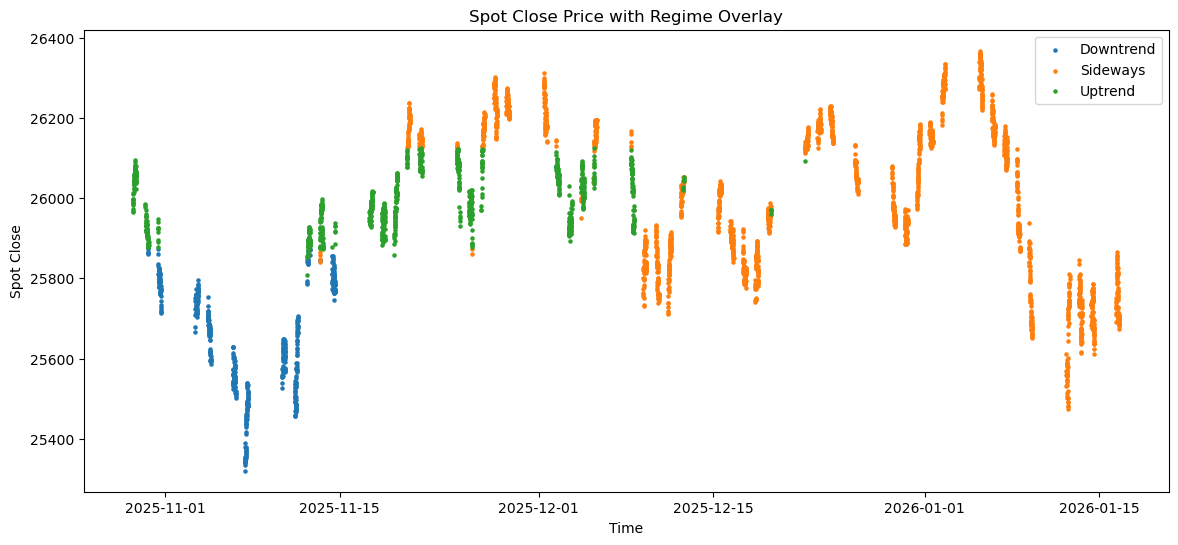


Transition Count Matrix:
      -1     0     1
-1  589     0    10
 0    0  2440    18
 1   10    19  1025

Transition Probability Matrix:
           -1         0         1
-1  0.983306  0.000000  0.016694
 0  0.000000  0.992677  0.007323
 1  0.009488  0.018027  0.972486


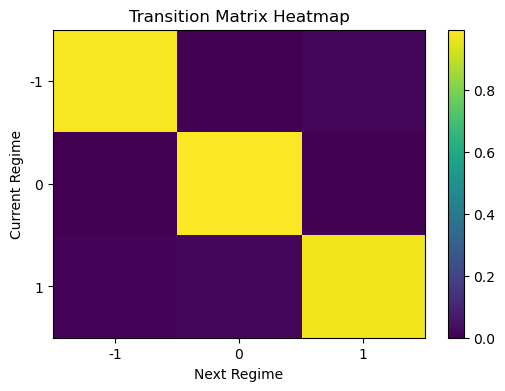


Regime Statistics:
           avg_iv                               iv_spread                      \
            mean       std       min       max      mean       std       min   
regime                                                                         
-1      0.404265  0.011015  0.373998  0.438143  0.305708  0.018931  0.255263   
 0      0.303886  0.066994  0.194253  0.457885  0.198965  0.076161  0.066277   
 1      0.545787  0.074949  0.378225  0.802418  0.469924  0.098345  0.270066   

                    pcr_oi            ...  vega_call            futures_basis  \
             max      mean       std  ...        min        max          mean   
regime                                ...                                       
-1      0.375441  4.603641  8.051181  ...  13.958685  14.263195      0.018453   
 0      0.417324  1.495559  0.414941  ...  14.065598  14.539580      0.007864   
 1      0.773759  1.714237  0.128138  ...  14.226464  14.399300      0.014731   

           

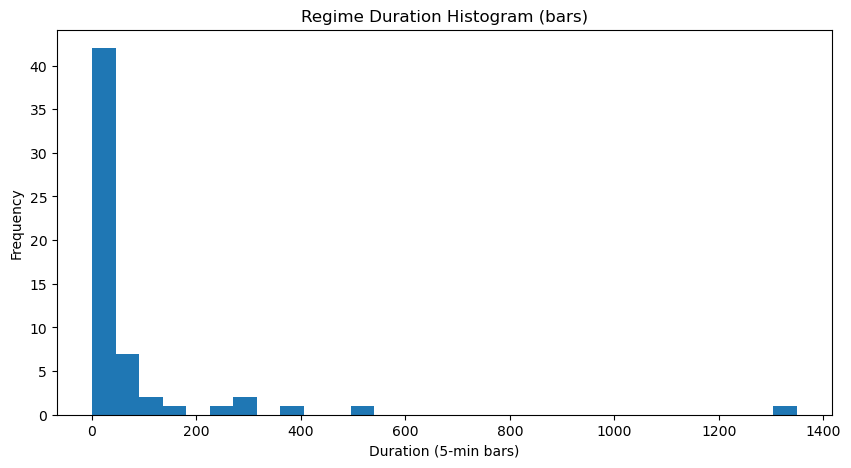


Saved: data_regime/nifty_with_regime_5min.csv
Final rows: 4112
Unique regimes: [ 1 -1  0]


In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

# =========================
# 1) Load features file
# =========================
df = pd.read_csv("data_features/nifty_features_5min.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# Create spot_returns (needed for HMM)
df["spot_returns"] = df["close"].pct_change()

# =========================
# 2) HMM Features (Project)
# =========================
hmm_features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",
    "delta_call",
    "gamma_call",
    "vega_call",
    "futures_basis",
    "spot_returns"
]

missing = [c for c in hmm_features if c not in df.columns]
print("Missing columns:", missing)

df_hmm = df.dropna(subset=hmm_features).copy().reset_index(drop=True)
print("After dropna:", df_hmm.shape)

# =========================
# 3) Scale + Train 70%
# =========================
X = df_hmm[hmm_features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

split = int(len(X_scaled) * 0.70)
X_train = X_scaled[:split]
X_test  = X_scaled[split:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# =========================
# 4) Fit HMM (3 states)
# =========================
model = GaussianHMM(
    n_components=3,
    covariance_type="diag",
    n_iter=300,
    random_state=42
)

model.fit(X_train)

df_hmm["state"] = model.predict(X_scaled)
print("State counts:\n", df_hmm["state"].value_counts())

# =========================
# 5) Map states -> regimes (-1,0,+1)
# =========================
state_returns = df_hmm.groupby("state")["spot_returns"].mean().sort_values()
print("\nMean spot_returns per state:\n", state_returns)

down_state = state_returns.index[0]
side_state = state_returns.index[1]
up_state   = state_returns.index[2]

mapping = {down_state: -1, side_state: 0, up_state: 1}
df_hmm["regime"] = df_hmm["state"].map(mapping)

print("\nRegime counts:\n", df_hmm["regime"].value_counts())

# =========================
# 6) Price chart with regime overlay
# =========================
plt.figure(figsize=(14,6))
for r, label in [(-1,"Downtrend"), (0,"Sideways"), (1,"Uptrend")]:
    temp = df_hmm[df_hmm["regime"] == r]
    plt.scatter(temp["timestamp"], temp["close"], s=5, label=label)

plt.title("Spot Close Price with Regime Overlay")
plt.xlabel("Time")
plt.ylabel("Spot Close")
plt.legend()
plt.show()

# =========================
# 7) Transition matrix heatmap
# =========================
reg = df_hmm["regime"].values
unique_regimes = [-1, 0, 1]

trans = pd.DataFrame(0, index=unique_regimes, columns=unique_regimes)

for i in range(len(reg)-1):
    trans.loc[reg[i], reg[i+1]] += 1

trans_prob = trans.div(trans.sum(axis=1), axis=0)

print("\nTransition Count Matrix:\n", trans)
print("\nTransition Probability Matrix:\n", trans_prob)

plt.figure(figsize=(6,4))
plt.imshow(trans_prob, aspect="auto")
plt.xticks(range(3), unique_regimes)
plt.yticks(range(3), unique_regimes)
plt.colorbar()
plt.title("Transition Matrix Heatmap")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()

# =========================
# 8) Regime statistics table
# =========================
stats_cols = [
    "avg_iv","iv_spread","pcr_oi","delta_call",
    "gamma_call","vega_call","futures_basis","spot_returns"
]

regime_stats = df_hmm.groupby("regime")[stats_cols].agg(["mean","std","min","max"])
print("\nRegime Statistics:\n", regime_stats)

# =========================
# 9) Duration histogram
# =========================
durations = []
current = df_hmm["regime"].iloc[0]
count = 1

for r in df_hmm["regime"].iloc[1:]:
    if r == current:
        count += 1
    else:
        durations.append((current, count))
        current = r
        count = 1

durations.append((current, count))

dur_df = pd.DataFrame(durations, columns=["regime","duration_bars"])
print("\nDuration Stats:\n", dur_df.groupby("regime")["duration_bars"].describe())

plt.figure(figsize=(10,5))
plt.hist(dur_df["duration_bars"], bins=30)
plt.title("Regime Duration Histogram (bars)")
plt.xlabel("Duration (5-min bars)")
plt.ylabel("Frequency")
plt.show()

# =========================
# 10) Save final regime output
# =========================
os.makedirs("data_regime", exist_ok=True)
save_path = "data_regime/nifty_with_regime_5min.csv"
df_hmm.to_csv(save_path, index=False)

print("\nSaved:", save_path)
print("Final rows:", df_hmm.shape[0])
print("Unique regimes:", df_hmm["regime"].unique())

In [13]:
thr = df_hmm["spot_returns"].std() * 0.5   # you can try 0.3, 0.5, 1.0

df_hmm["regime_fixed"] = 0
df_hmm.loc[df_hmm["spot_returns"] > thr, "regime_fixed"] = 1
df_hmm.loc[df_hmm["spot_returns"] < -thr, "regime_fixed"] = -1

print(df_hmm["regime_fixed"].value_counts())

regime_fixed
 0    2096
-1    1011
 1    1005
Name: count, dtype: int64


In [14]:
df_hmm.to_csv("data_regime/nifty_with_regime_fixed_5min.csv", index=False)
print("Saved: data_regime/nifty_with_regime_fixed_5min.csv")

Saved: data_regime/nifty_with_regime_fixed_5min.csv
